**Problem statement:**

1.This is the data from datadriven.org and collected from Tanzanian ministry of water to
predict which pumps are functional, not functional and which pumps needs
repair. This is a real world problem which engages citizens of Tanzania with
local government.

2.We need to predict one of three class labels based on the features like
operating conditions, geographic location of water point, manufactured
organization, population around the water point and operators of the water
point and sources of water point.

3.Good understanding of this problem will improve maintenance operations of
the water points and ensure clean and seamless water supply is available to
communities across Tanzania.



**Business constraints:**

1.No low latency requirements.

2.Cost of error is high because operational cost will increase for each misclassification.


**Mapping in to ML problem**

1.This is a multi class classification problem where there is huge imbalance across class labels in dataset so we need to take micro average F1 score as an performance metric to accomodate class imbalance.

2.In this case both true positives and true negatives are important because for an example if we take pump with repair as positive class but we predicted as negative i.e, false positive there is an interruption of water at water point so TP are important and if we take pump with functional as negative class and we predicted as positive i.e, false negative due to this breakdown maintenance cost will increase so in this case TP and TN both are important.

**#https://www.kaggle.com/code/enforcer007/what-is-micro-averaged-f1-score/notebook**

**#https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin**

**#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/**

**Existing solutions:**

**#https://www.researchgate.net/publication/345888631_Pump_it_Up_Data_Mining_the_Water_Table**

**#https://medium.com/@vaibhavshukla182/pump-it-up-data-mining-the-water-table-f903d4cfc7a8#:~:text=It%20is%20an%20online%20data,don't%20work%20at%20all.**

1.In the above solutions they performed EDA on all columns and get additional feature like how old the pumps are by subtracting date recorded of the pump and construction year of the pump and found out that older the pumps are more is the class label pumps with repair.

2.The amount tsh means total static head feature i.e, amount of water availabe at the water point is right skewed distribution so applied log transformation to smoothen it yielded good result in  featurization.

3.additional feature was amount of well water related to population it will get amount_tsh feature divided by population.

4.In the installer and funder features there is lots of diiferent values so replaced with 20 most frequent values that helped to get good accuracy.

5.Deleted correlated features and applied one hot encoding to categorical features and smote technique to tackle imbalance probelm.

6.By the approach they are getting aroung 81% accuracy by applying algorithms like random forest and XG boosting.

7.we will take important points from above solutions to solve our problem.

In [ ]:
import warnings 
warnings.filterwarnings('ignore')
# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
!pip install gpxpy
import gpxpy.geo #Get the haversine distance
!pip3 install folium
# if this doesnt work refere install_folium.JPG in drive
import folium #open street map
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 6.9 MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.5.0-py3-none-any.whl size=42898 sha256=e4eba73e1bd127539ee62162c17d9aa0bdb36c979de79f413c67c57545e76030
  Stored in directory: /root/.cache/pip/wheels/78/49/b6/d1851fcb4ee10fa784325d7fcf6c97789157c706ab3a71e2b6
Successfully built gpxpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_train=pd.read_csv("/content/Train_data.csv")
df_label=pd.read_csv("/content/Train_class_labels.csv")
test_data=pd.read_csv("/content/Train_data.csv")

In [ ]:
train_data=pd.concat([df_train,df_label], axis=1)

**Categorical and continuous features**

In [ ]:
# https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical

categorical_features = [i for i in list(train_data.select_dtypes(include=['object']).columns)if i not in ['status_group']]
print("Categorical features in Train data : {} features".format(len(categorical_features)))

Categorical features in Train data : 30 features


In [ ]:
# https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical
continous_features = [i for i in list(df_train.select_dtypes(include=['float64', 'int64']).columns) if i not in ['id']]
print("Continuous features in Train data : {} features".format(len(continous_features)))

Continuous features in Train data : 9 features


Observations:

There are 30 categorical features and 9 continuous features in our dataset.

**Checking for class imbalance**

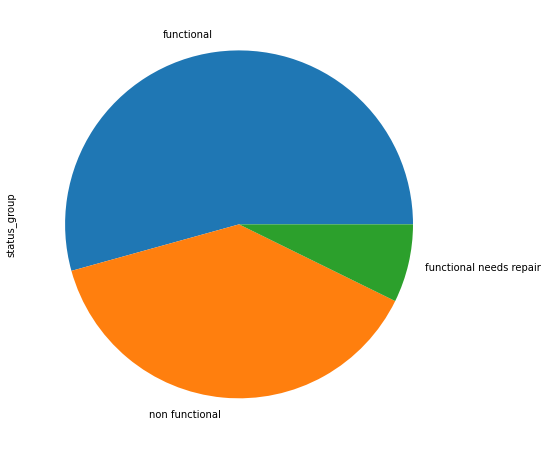

In [ ]:
#https://www.moonbooks.org/Articles/How-to-extract-the-value-names-and-counts-from-valuecounts-in-pandas-/
train_data['status_group'].value_counts().plot(kind='pie',figsize=(15,8))
plt.show()

Observations:

As per above figure we observed that classes are imbalanced so we need to 
design an machine learning algorithm and selecting performance metric so that it has low impact.

**Checking for null values**

In [ ]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [ ]:
nan_df_create(train_data)

,column,percent
21,scheme_name,47.417508
20,scheme_management,6.526936
5,installer,6.153199
3,funder,6.119529
18,public_meeting,5.612795
22,permit,5.144781
11,subvillage,0.624579
31,water_quality,0.000000
26,extraction_type_class,0.000000
27,management,0.000000


In [ ]:
nan_df_create(test_data)

,column,percent
21,scheme_name,47.417508
20,scheme_management,6.526936
5,installer,6.153199
3,funder,6.119529
18,public_meeting,5.612795
22,permit,5.144781
11,subvillage,0.624579
28,management_group,0.000000
38,waterpoint_type,0.000000
24,extraction_type,0.000000


Observations:

There are 7 columns which has null values in train data and test data

**EDA on Latitude and Longitude with region**

These are region wise data collected from https://www.latlong.net/place/iringa-iringa-district-tanzania-24674.html

Iringa- -7.773094, 35.699120







Shinyanga  -3.680996, 33.42713

Mbeya -8.909401, 33.460773

kili-3.065653, 37.352013

morogoro  -6.830373, 37.670589

arusha -3.386925, 36.682995

mawanja -15.609150, 34.522820

kagera -1.9167, 31.3000

kigoma -4.893941, 29.673386

ravuma -10.52023, 35.42542

pawami -7.0000, 39.0000

tanga -5.0667 39.1000

Dodoma -6.161184 35.745426

Singida -6.745335,34.153195

tabora -5.030461,32.819431

Rukwa -7.0000 ,31.5000

matwara -10.66667 ,39

manyara -3.5833,35.8333

Lindi -9.987608, 39.698248

Dar es Salaam-6.776012, 39.178326



In [ ]:
train_data['region'].unique()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

**Box plots for Latitude and Longitude features**

Preparing data to visualize latitude and longitude

In [ ]:
df2=train_data[['region','latitude','longitude']]
df2.set_index("region", inplace = True)

In [ ]:
df_Iringa=df2.loc[["Iringa"],["latitude","longitude"]]
df_Mara=df2.loc[["Mara"],["latitude","longitude"]]
df_Manyara=df2.loc[["Manyara"],["latitude","longitude"]]
df_Mtwara=df2.loc[["Mtwara"],["latitude","longitude"]]
df_Kagera=df2.loc[["Kagera"],["latitude","longitude"]]
df_Tanga=df2.loc[["Tanga"],["latitude","longitude"]]
df_Shinyanga=df2.loc[["Shinyanga"],["latitude","longitude"]]
df_Tabora=df2.loc[["Tabora"],["latitude","longitude"]]
df_Pwani=df2.loc[["Pwani"],["latitude","longitude"]]
df_Ruvuma=df2.loc[["Ruvuma"],["latitude","longitude"]]
df_Kilimanjaro=df2.loc[["Kilimanjaro"],["latitude","longitude"]]
df_Rukwa=df2.loc[["Rukwa"],["latitude","longitude"]]
df_Mwanza=df2.loc[["Mwanza"],["latitude","longitude"]]
df_Kigoma=df2.loc[["Kigoma"],["latitude","longitude"]]
df_Lindi=df2.loc[["Lindi"],["latitude","longitude"]]
df_Dodoma=df2.loc[["Dodoma"],["latitude","longitude"]]
df_Arusha=df2.loc[["Arusha"],["latitude","longitude"]]
df_Mbeya=df2.loc[["Mbeya"],["latitude","longitude"]]
df_Singida=df2.loc[["Singida"],["latitude","longitude"]]
df_Morogoro=df2.loc[["Morogoro"],["latitude","longitude"]]
df_Dar_es_Salaam=df2.loc[["Dar es Salaam"],["latitude","longitude"]]

**Latitudes**

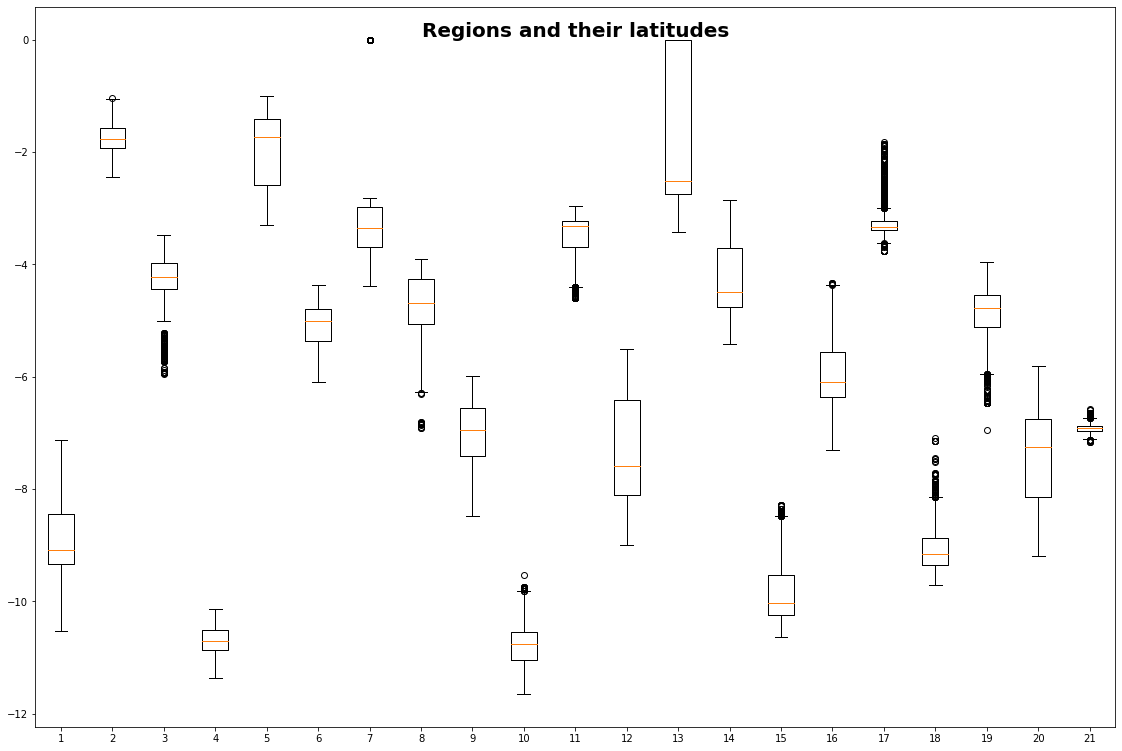

In [ ]:
data_region=[df_Iringa['latitude'],df_Mara['latitude'],df_Manyara['latitude'],df_Mtwara['latitude'],df_Kagera['latitude'],df_Tanga['latitude']\
             ,df_Shinyanga['latitude'],df_Tabora['latitude'],df_Pwani['latitude'],df_Ruvuma['latitude'],df_Kilimanjaro['latitude'],df_Rukwa['latitude']\
             ,df_Mwanza['latitude'],df_Kigoma['latitude'],df_Lindi['latitude'],df_Dodoma['latitude'],df_Arusha['latitude'],df_Mbeya['latitude'],df_Singida['latitude']
             ,df_Morogoro['latitude'],df_Dar_es_Salaam['latitude']]
fig = plt.figure(figsize =(15, 10))
fig.suptitle('Regions and their latitudes', fontsize=20, fontweight='bold')
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
plt.boxplot(data_region)
# show plot
plt.show()

Observations:

From the above plots we observed lot of extreme values so we will try to fill with median imputation.

**Longitudes**

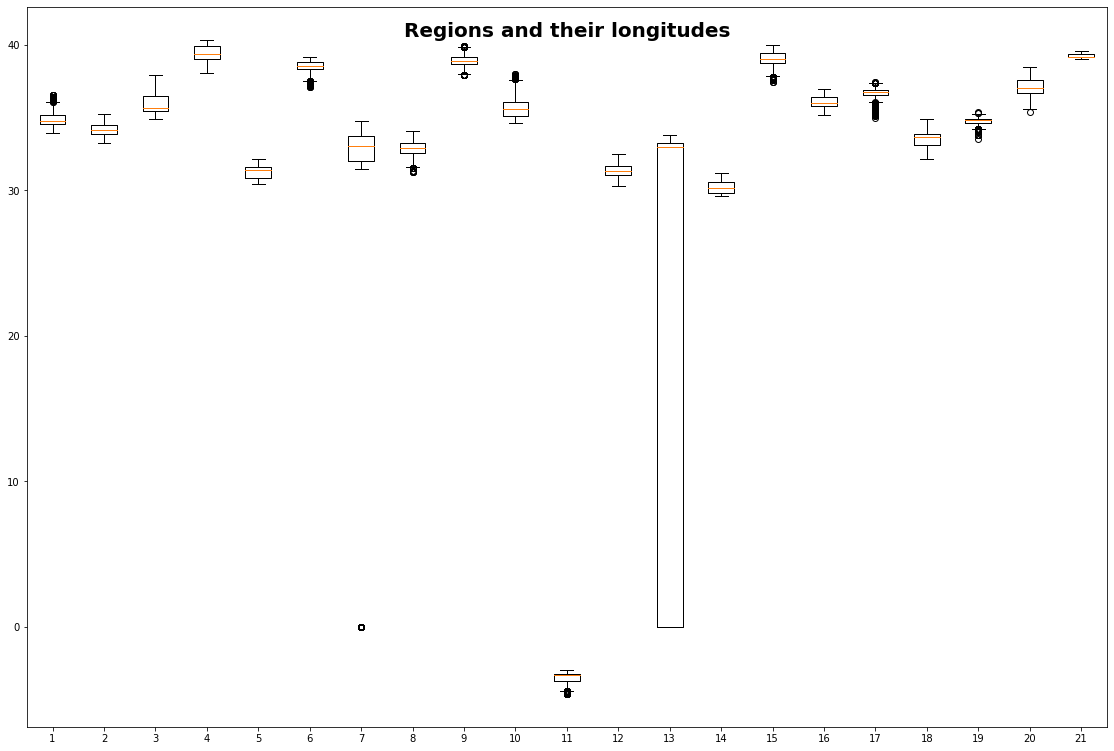

In [ ]:
data_region2=[df_Iringa['longitude'],df_Mara['longitude'],df_Manyara['longitude'],df_Mtwara['longitude'],df_Kagera['longitude'],df_Tanga['longitude']\
             ,df_Shinyanga['longitude'],df_Tabora['longitude'],df_Pwani['longitude'],df_Ruvuma['longitude'],df_Kilimanjaro['latitude'],df_Rukwa['longitude']\
             ,df_Mwanza['longitude'],df_Kigoma['longitude'],df_Lindi['longitude'],df_Dodoma['longitude'],df_Arusha['longitude'],df_Mbeya['longitude'],df_Singida['longitude']
             ,df_Morogoro['longitude'],df_Dar_es_Salaam['longitude']]
fig = plt.figure(figsize =(15, 10))
fig.suptitle('Regions and their longitudes', fontsize=20, fontweight='bold')
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
plt.boxplot(data_region2)
# show plot
plt.show()

Observations:

From the above plots we observed lot of extreme values so we will try to fill with median imputation.

**Visualising outliers in region**

In [ ]:
outlier_locations = df2[((df2.longitude >= 39) | (df2.latitude <= -15))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html


map_osm = folium.Map(location=[39.698298, -15.609150], tiles='Stamen Toner')
# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(100)
for i,j in sample_locations.iterrows():
    if int(j['latitude']) != 0:
        folium.Marker(list((j['latitude'],j['longitude']))).add_to(map_osm)
map_osm

Observations:

We had observed from above plots latitudes and longitudes values are some what corrputed from border areas of tanzania.

**Pdf of continuous features**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f848b42ce50>,
      dtype=object)

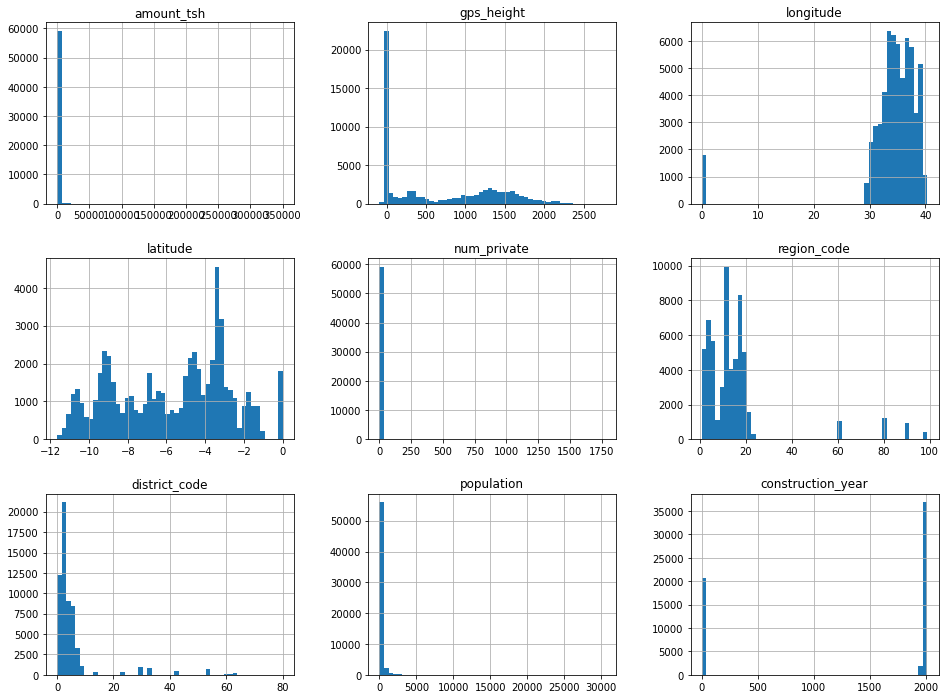

In [ ]:
train_data[continous_features].hist(bins=50, figsize=(16,12))

Observations:

1.Above plot we had observed that amount_tsh pdf is right skewed so we apply log transormation to smoothen it and check.

2.Remaining plots are slightly hard to interpret as there are not following proper distributions.

**pdf of amount_tsh**

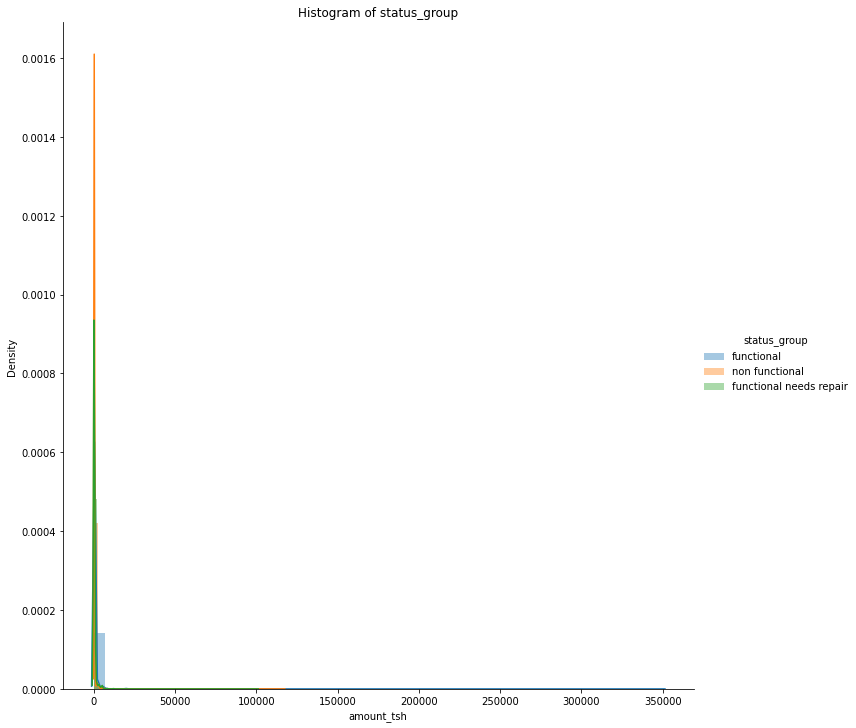

In [ ]:
sns.FacetGrid(train_data, hue="status_group", size=10) \
   .map(sns.distplot, "amount_tsh") \
   .add_legend();
plt.title("Histogram of status_group")
plt.ylabel("Density")
plt.show()

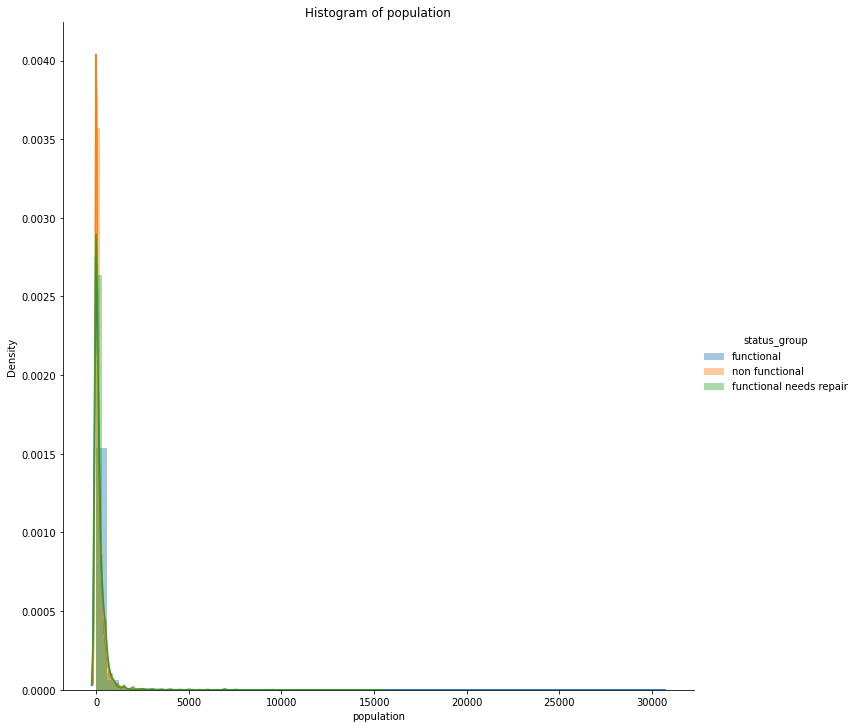

In [ ]:
sns.FacetGrid(train_data, hue="status_group", size=10) \
   .map(sns.distplot, "population") \
   .add_legend();
plt.title("Histogram of population")
plt.ylabel("Density")
plt.show()

**Log transformation**

In [ ]:
log_amt_tsh=[]
for i in train_data['amount_tsh']:
  log_amt=np.log(i+0.0001)
  log_amt_tsh.append(log_amt)

In [ ]:
train_data['amount_tsh_log']=log_amt_tsh

**Plot for Log tranformed Amount_tsh feature**

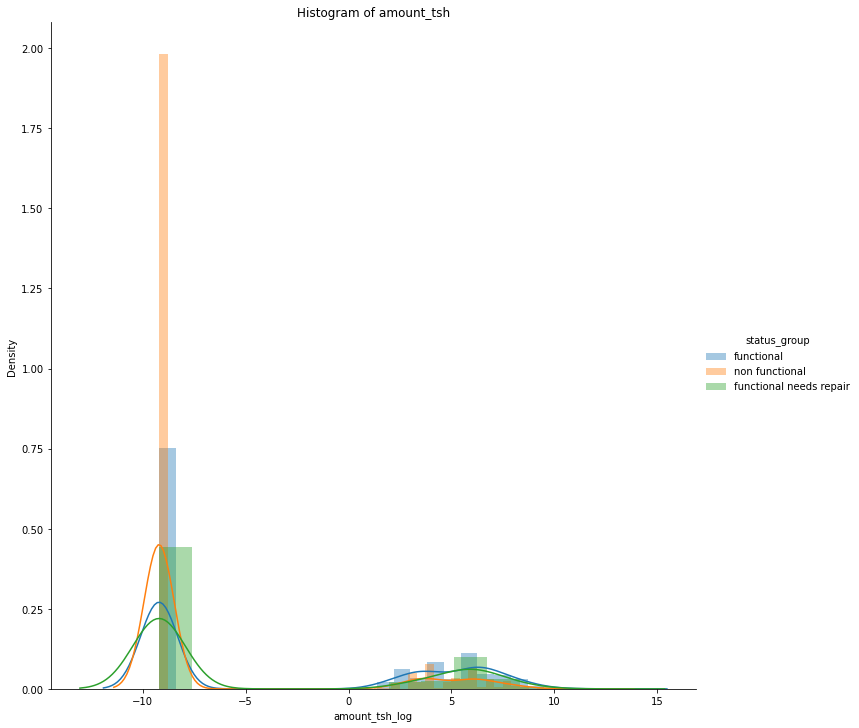

In [ ]:
sns.FacetGrid(train_data, hue="status_group", size=10) \
   .map(sns.distplot, "amount_tsh_log") \
   .add_legend();
plt.title("Histogram of amount_tsh")
plt.ylabel("Density")
plt.show()

Observations:

After applying log tranformation most of the data obtained right skewed and some part following like normal distribution.

**Q-Q plot**

In [ ]:
from statsmodels.graphics.gofplots import qqplot 
from scipy.stats import norm

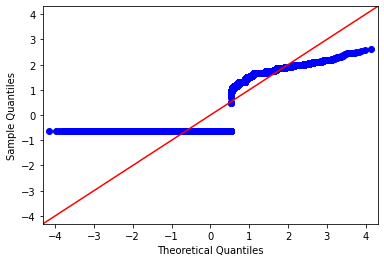

In [ ]:
#https://towardsdatascience.com/how-to-use-q-q-plot-for-checking-the-distribution-of-our-data-c798d0577369
qqplot(train_data['amount_tsh_log'],norm,fit=True,line="45") 
plt.show()

**Observations:**

We found that after applying log to feature amount_tsh it does not following normal distribution

**Log tranformation for population feature**

In [ ]:
# Calculate logarithm to base 2 
# on 'Salary' column
log_population_tra=[]
for i in train_data['population']:
  log_population=np.log(i+1)
  log_population_tra.append(log_population)

In [ ]:
train_data['log_population_tra']=log_population_tra #adding columns to train data

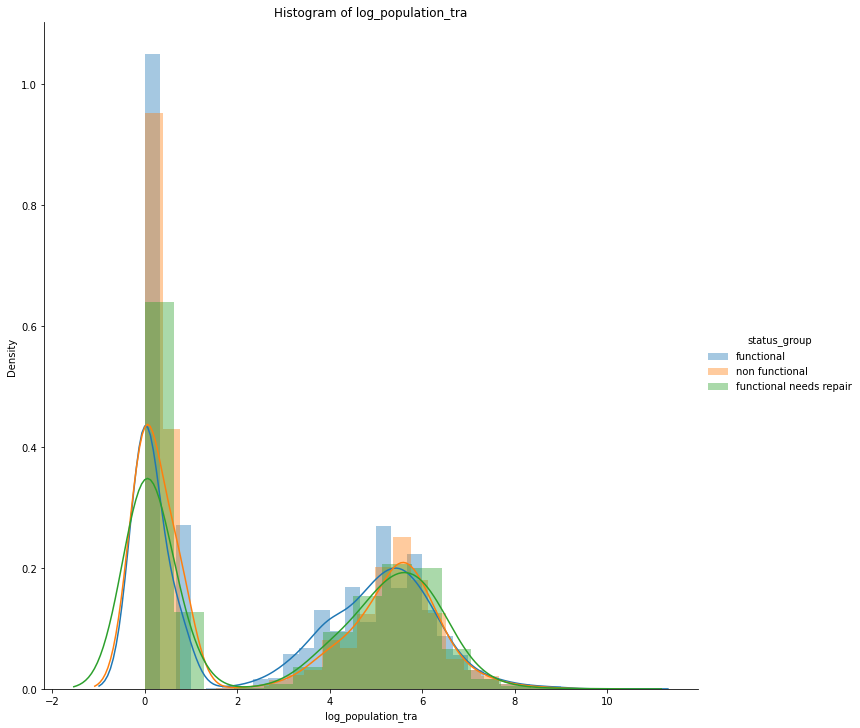

In [ ]:
sns.FacetGrid(train_data, hue="status_group", size=10) \
   .map(sns.distplot, "log_population_tra") \
   .add_legend();
plt.title("Histogram of log_population_tra")
plt.ylabel("Density")
plt.show()

Observations:

After applying log tranformation most of the data obtained right skewed and we do not interpret anything from this plot.

**Cdf plots for population feature:**

[    0.  3050.  6100.  9150. 12200. 15250. 18300. 21350. 24400. 27450.
 30500.]


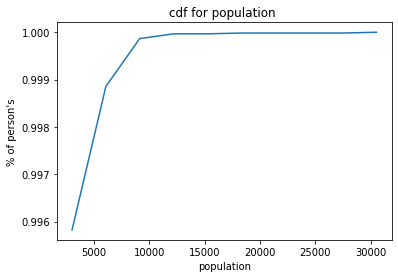

In [ ]:
counts, bin_edges = np.histogram(train_data['population'], bins=10,density = True)
pdf = counts/(sum(counts))
print(bin_edges)
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.title("cdf for population ")
plt.xlabel("population")
plt.ylabel("% of person's")
plt.show();

Observations:

above plot indicates that 99% percent of all region population 5000 approximately.

**Correlation plots:**

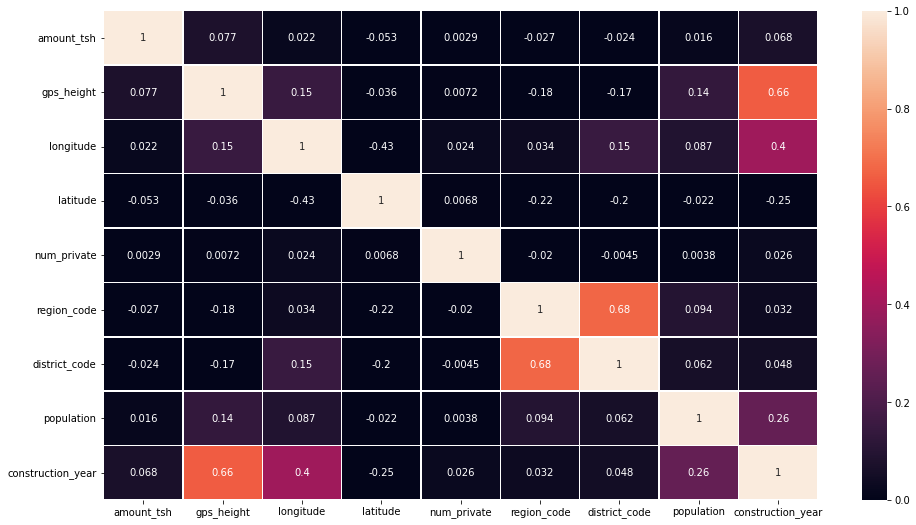

In [ ]:
plt.subplots(figsize=(16,9))
correlation_matrix = df_train[continous_features].corr()
sns.heatmap(correlation_matrix, annot=True,vmin=0, vmax=1,linewidths=.5)

Observations:

Above correlation heat map indicates region code and district code are correlated and gps_height and construction year are also correlated.

**Calculating operational year**

We can calculate operational year of pump by substracting date recorded to construction year

In [ ]:
train_data.construction_year

0        1999
1        2010
2        2009
3        1986
4           0
         ... 
59395    1999
59396    1996
59397       0
59398       0
59399    2002
Name: construction_year, Length: 59400, dtype: int64

In [ ]:
#https://github.com/vaibhavshukla182/Tanzania-Water-Supply/blob/master/data_visualisation_and_cleaning.ipynb
train_data['date_recorded'] = pd.to_datetime(train_data['date_recorded'])
train_data['operational_year'] = train_data.date_recorded.dt.year - train_data.construction_year
train_data.operational_year.head(5)

0      12
1       3
2       4
3      27
4    2011
Name: operational_year, dtype: int64

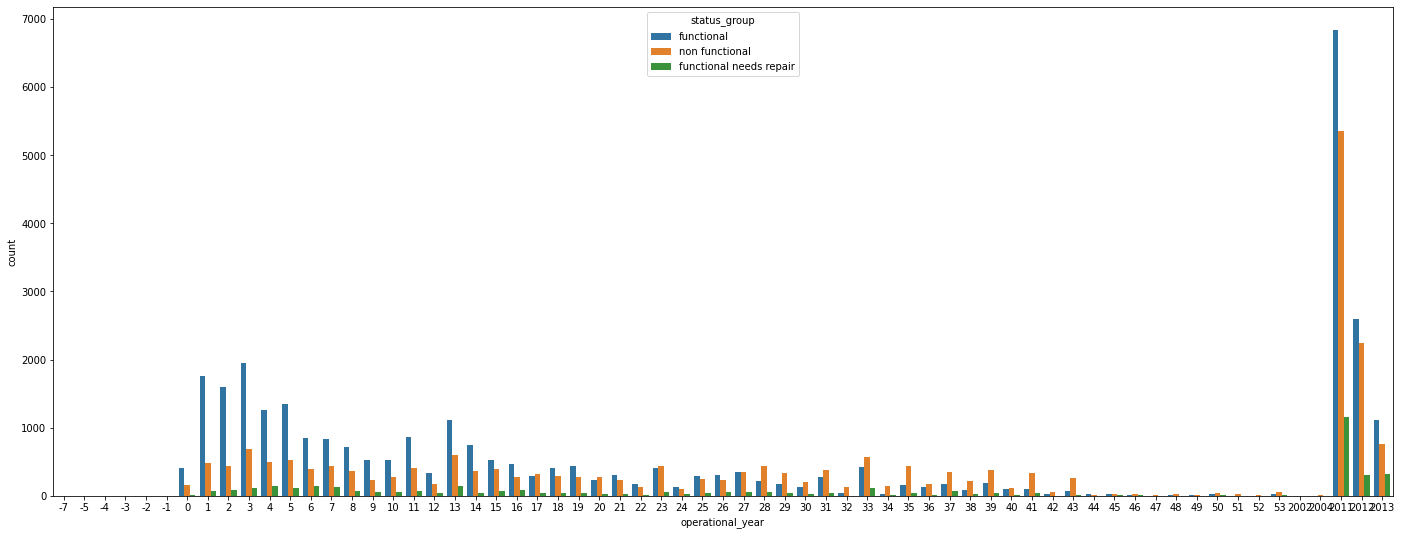

In [ ]:
plt.figure(figsize=(24, 9))
sns.countplot(data=train_data,x='operational_year',hue='status_group')

Observations:

From the above plot we conclude that construction year has zero values so we can fill with median values and see the plot again.

In [ ]:
train_data['construction_year'].replace(to_replace = 0, value = train_data['construction_year'].median(), inplace=True)

In [ ]:
#https://github.com/vaibhavshukla182/Tanzania-Water-Supply/blob/master/data_visualisation_and_cleaning.ipynb
train_data['date_recorded'] = pd.to_datetime(train_data['date_recorded'])
train_data['operational_year'] = train_data.date_recorded.dt.year - train_data.construction_year
train_data.operational_year.head(5)

0      12
1       3
2       4
3      27
4    2011
Name: operational_year, dtype: int64

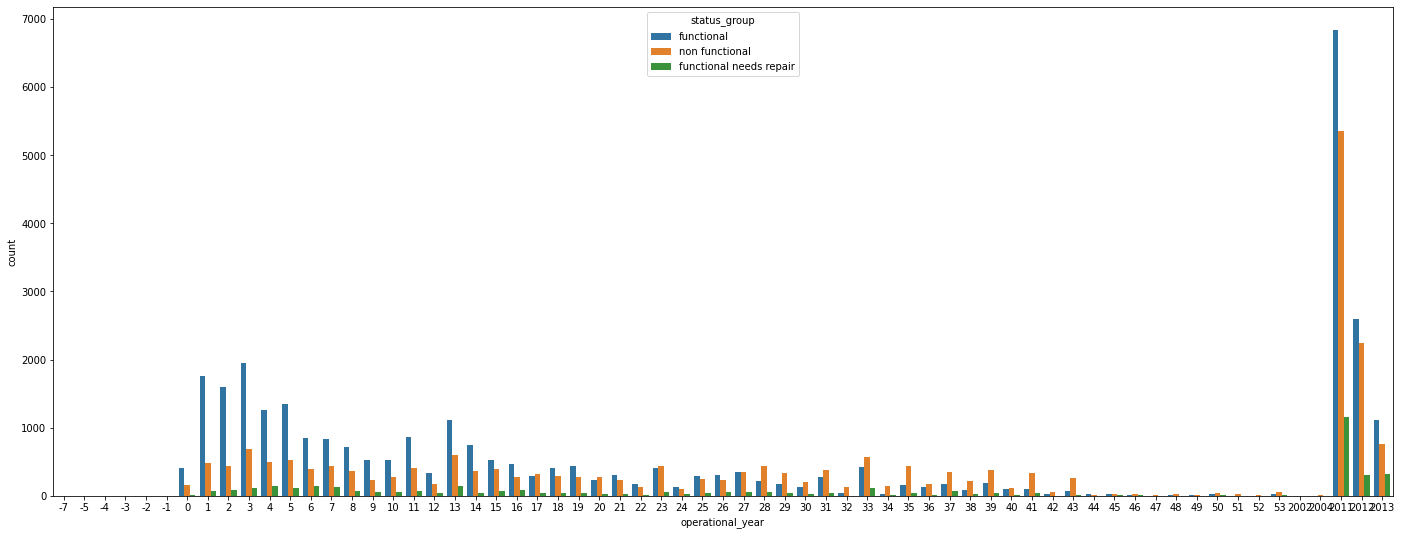

In [ ]:
plt.figure(figsize=(24, 9))
sns.countplot(data=train_data,x='operational_year',hue='status_group')

Observations:

We can see from above plot if the pump operational year are increasing it is getting non functional or functional needs repair.

**Impact of water quality on pumps**

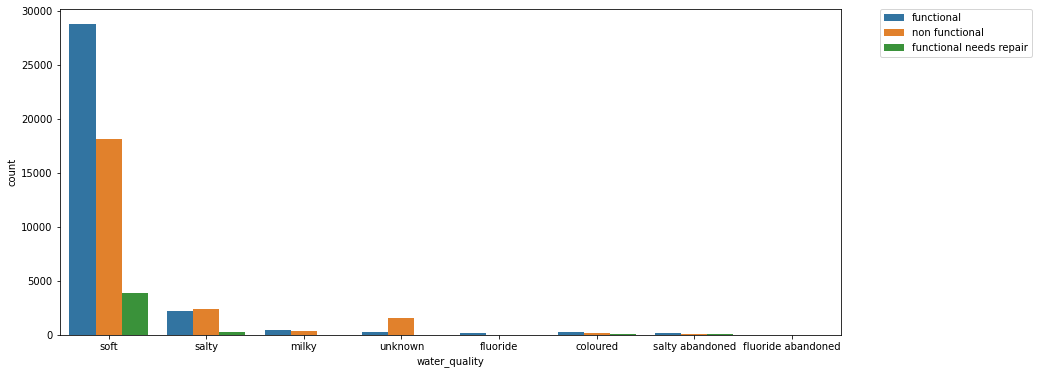

In [ ]:
plt.figure(figsize=(14,6))
sns.countplot(data=train_data,x='water_quality',hue='status_group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Observations:

Above plot indicates that soft water has less impact on pumps while salty water has more non functional pumps.

**Impact of source_type on pumps**

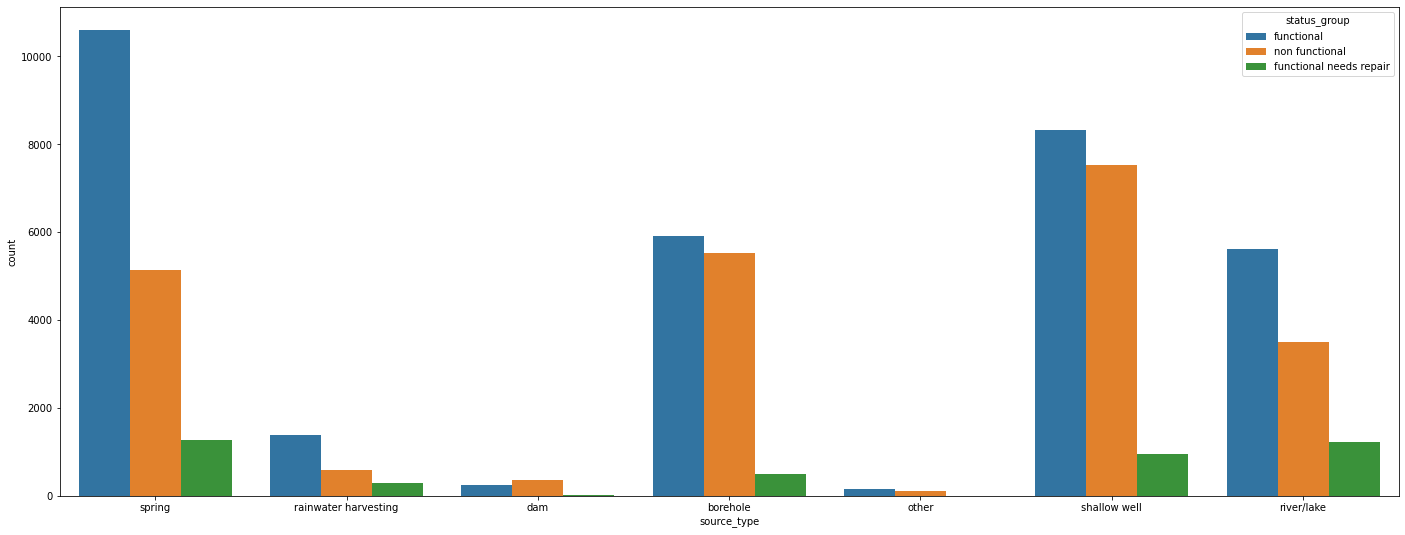

In [ ]:
plt.figure(figsize=(24, 9))
sns.countplot(data=train_data,x='source_type',hue='status_group')

Observations:

Above plot indicates that borehole and shallow well source type of water points has high non functional pumps.

**Impact of quantity on pumps**

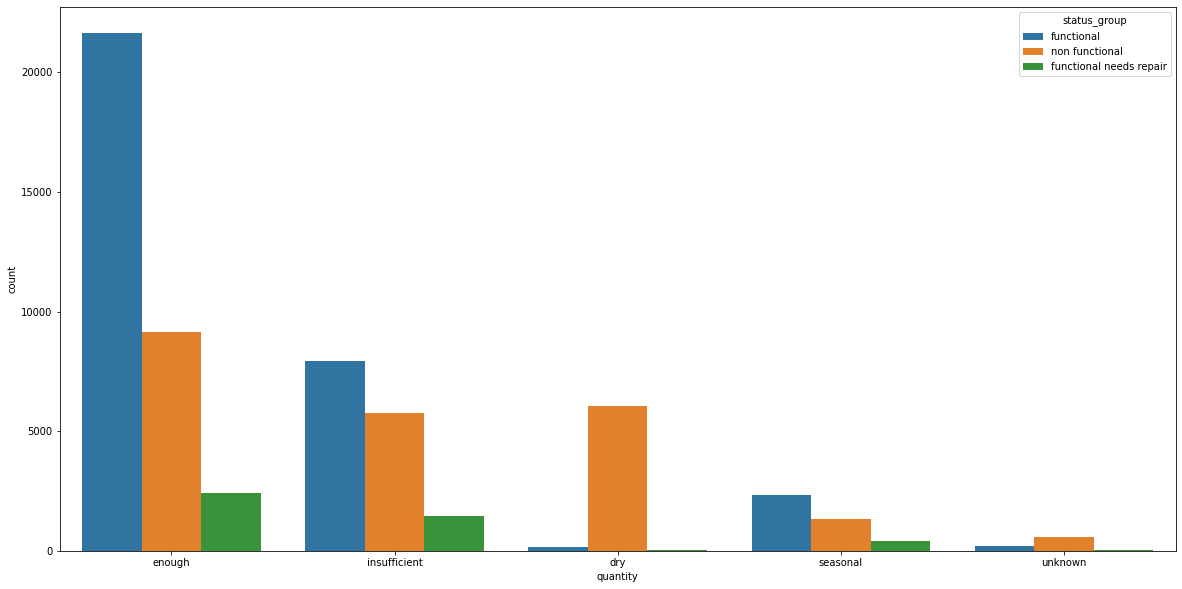

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(data=train_data,x='quantity',hue='status_group')

Observations:

Above plot clearly indicates that dry quantity has lot of non functional water points.

**Duplicate Features**

In [ ]:
train_data.groupby(['management', 'management_group']).size() 

management        management_group
company           commercial            685
other             other                 844
other - school    other                  99
parastatal        parastatal           1768
private operator  commercial           1971
trust             commercial             78
unknown           unknown               561
vwc               user-group          40507
water authority   commercial            904
water board       user-group           2933
wua               user-group           2535
wug               user-group           6515
dtype: int64

In [ ]:
train_data.groupby(['source', 'source_type']).size() 

source                source_type         
dam                   dam                       656
hand dtw              borehole                  874
lake                  river/lake                765
machine dbh           borehole                11075
other                 other                     212
rainwater harvesting  rainwater harvesting     2295
river                 river/lake               9612
shallow well          shallow well            16824
spring                spring                  17021
unknown               other                      66
dtype: int64

In [ ]:
train_data.groupby(['extraction_type_group','extraction_type']).size()

extraction_type_group  extraction_type          
afridev                afridev                       1770
gravity                gravity                      26780
india mark ii          india mark ii                 2400
india mark iii         india mark iii                  98
mono                   mono                          2865
nira/tanira            nira/tanira                   8154
other                  other                         6430
other handpump         other - mkulima/shinyanga        2
                       other - play pump               85
                       other - swn 81                 229
                       walimi                          48
other motorpump        cemo                            90
                       climax                          32
rope pump              other - rope pump              451
submersible            ksb                           1415
                       submersible                   4764
swn 80                 

In [ ]:
train_data.groupby(['waterpoint_type', 'waterpoint_type_group']).size() 

waterpoint_type              waterpoint_type_group
cattle trough                cattle trough              116
communal standpipe           communal standpipe       28522
communal standpipe multiple  communal standpipe        6103
dam                          dam                          7
hand pump                    hand pump                17488
improved spring              improved spring            784
other                        other                     6380
dtype: int64

In [ ]:
train_data.groupby(['quantity', 'quantity_group']).size() 

quantity      quantity_group
dry           dry                6246
enough        enough            33186
insufficient  insufficient      15129
seasonal      seasonal           4050
unknown       unknown             789
dtype: int64

In [ ]:
train_data.groupby(['payment', 'payment_type']).size() 

payment                payment_type
never pay              never pay       25348
other                  other            1054
pay annually           annually         3642
pay monthly            monthly          8300
pay per bucket         per bucket       8985
pay when scheme fails  on failure       3914
unknown                unknown          8157
dtype: int64

In [ ]:
train_data.groupby(['water_quality', 'quality_group']).size() 

water_quality       quality_group
coloured            colored            490
fluoride            fluoride           200
fluoride abandoned  fluoride            17
milky               milky              804
salty               salty             4856
salty abandoned     salty              339
soft                good             50818
unknown             unknown           1876
dtype: int64

**#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html**

**Observations:**

From the above groupby functions indicates that features will contain same information so we can drop those columns.


**Total observations and implementations for feature engineering:**

1.we need to fill with NAN/other as a category to accomodate for missing values in scheme, scheme_management, installer and funder.

2.We will drop date_recorded and construction year as we introduced operation year from that features.

3.For feature engineering we can use encoding techniques like one hot encoding or label encoding.

4.As per correlation plot district_code and region_code are correlated so we can drop one feature.

5.Latitude and longitude features have lot of extreme values so we can fill with median imputation for that features.